# QOSF Mentorship Programme Screening - Mark Cunningham
## Task 1
Hello! This is my attempt at tackling task 1 for the screening tasks. Overall, I found the learning experience very fun. It was my first time doing a full optimization task. 

## The Task
We needed to implement a 4 qubit-state consisting of a number of "Layers". One layer is made up by an "odd" block and an "even" block. 

An odd block is an Rx gate on each qubit, with an even block being Rz gates and a combination of Cz gates. Rx and Rz gates rotated with a parameter theta.

The statevector of this circuit was our variable "psi" and we also calculated a random 4-qubit state "phi". 

We needed to calculate the minimum possible value of the distance between these two values, with a certain combination of "theta" parameters.

In essence, this is an optimization problem.

We wanted to investigate how the number of layers in the circuit impacted our end "minimum distance" result.
The end deliverable is a graph showing this!

## Let's Get Stuck In!
For this task I will be using Qiskit.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib inline

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import gate
from qiskit.quantum_info import random_statevector
from qiskit.aqua.components.optimizers import COBYLA, ADAM
from qiskit.compiler import transpile

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
simulator = Aer.get_backend('statevector_simulator')

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
def layer(circuit,theta_params):
    """
    Function that constructs a layer within a circuit.
    
    Parameters:
        circuit: Qiskit Circuit Object
        thera_params (list): 8 Parameters, one for each gate in the layer.
    
    Returns:
        circuit: New Qiskit Circuit object with layer added
    """
    #Odd Block
    circuit.rx(theta_params[0],0)
    circuit.rx(theta_params[1],1)
    circuit.rx(theta_params[2],2)
    circuit.rx(theta_params[3],3)
    #Even Block
    circuit.rz(theta_params[4],0)
    circuit.rz(theta_params[5],1)
    circuit.rz(theta_params[6],2)
    circuit.rz(theta_params[7],3)
    circuit.cz(0,1)
    circuit.cz(0,2)
    circuit.cz(0,3)
    circuit.cz(1,2)
    circuit.cz(1,3)
    circuit.cz(2,3)
    return circuit


def layer_calculation(circuit,params):
    """
    Calculates each layer in batches of 8 parameters, as there are 8 per layer
    """
    for i in range(0,len(params), 8):
        circuit = layer(circuit,params[i:i+8])
    return circuit


def construct_circuit(params):
    """Builds the circuit with the necessary number of layers"""
    circuit = QuantumCircuit(4)
    circuit = layer_calculation(circuit,params)
    return circuit


def run_circuit(circuit,simulator= Aer.get_backend('statevector_simulator'), number_of_shots=100):
    """Runs the circuit to get the statevector"""
    job = execute(circuit, simulator, shots=number_of_shots)            
    resultant_state = job.result().get_statevector()
    return resultant_state

In [3]:
#random_statevector stuff
def random_circuit():
    "Generates random circuit"
    state = random_statevector(4) # note: the parameter you pass is the number of entries in the vector, not the number of qubits
    qc = QuantumCircuit(4,4)
    qc.initialize(state.data, [0,3])
    return qc

In [4]:
def distance_function(circuit_state,random_state):
    """
    Calculates distance between two vectors
    """
    state_difference = circuit_state-random_state
    distance = np.linalg.norm(state_difference,ord=2) 
    return distance

In [5]:
def cost_function(params):
    """
    This is the cost function to be minimised.
    
    Parameters:
        params: a list containing all theta values needed to build the circuit.
    """
    global random_state_global # Ugly method, but easiest way of passing in a new random circuit.
    circuit = construct_circuit(params)
    state = run_circuit(circuit, simulator)
    distance = distance_function(state,random_state_global)
    return distance # our end deliverable

In [6]:
def optimizers():
    # Chosen optimisers for cost function minimising
    cob = COBYLA(1000, tol=0.0001, rhobeg=2) # initialising
    adam = ADAM(1000, tol =0.0001) #initialising
    return cob,adam

In [7]:
def main():
    """
    I'm so sorry for how messy this function is
    """
    #preparing optimizers
    cob,adam = optimizers()
    
    # where our results are stored
    returned_values_cobyla = []
    returned_values_adam = []

    #new circuit for each number of layers
    for number_of_layers in range (1,11):

        # initialising between 0 and 2Pi
        params = [random.uniform(0,2*np.pi) for i in range(8 * number_of_layers)]
        
        bounds = []
        for param in params:
            bounds.append((0, 2*np.pi)) # bounds for optimiser

        ret1 = cob.optimize(num_vars=8 * number_of_layers,
                         objective_function=cost_function,
                         initial_point=params,
                         variable_bounds=bounds)
        returned_values_cobyla.append(ret1)
        print("---- Appended cobyla ----" + str(number_of_layers))

        ret2 = adam.optimize(num_vars=8 * number_of_layers,
                         objective_function=cost_function,
                         initial_point=params,
                         variable_bounds=bounds)
        returned_values_adam.append(ret2)
        print("---- Appended adam ----" + str(number_of_layers))
    
    #only returning the end Epsilon values (rather than also our thetas)
    cobyla_results = [i[1] for i in returned_values_cobyla]
    adam_results = [i[1] for i in returned_values_adam]
        
    return (cobyla_results, adam_results)

In [8]:
# defining random state - global variable to be used in cost_function()
#I know this isn't ideal but it's the quickest solution right now
#Currently looking at how to use it as a parameter in the optimizer
random_state_global = run_circuit(random_circuit()) 

(cobyla_results, adam_results) = main()

---- Appended cobyla ----1
---- Appended adam ----1
---- Appended cobyla ----2
---- Appended adam ----2
---- Appended cobyla ----3
---- Appended adam ----3
---- Appended cobyla ----4
---- Appended adam ----4
---- Appended cobyla ----5
---- Appended adam ----5
---- Appended cobyla ----6
---- Appended adam ----6
---- Appended cobyla ----7
---- Appended adam ----7
---- Appended cobyla ----8
---- Appended adam ----8
---- Appended cobyla ----9
---- Appended adam ----9
---- Appended cobyla ----10
---- Appended adam ----10


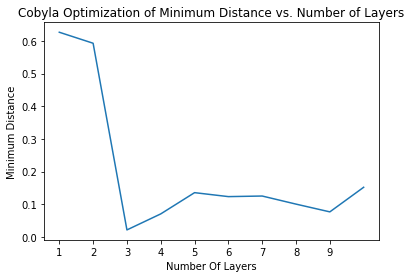

In [15]:
plt.title("Cobyla Optimization of Minimum Distance vs. Number of Layers")
plt.xlabel("Number Of Layers")
plt.ylabel("Minimum Distance")
plt.xticks(np.arange(10))
plt.plot([i for i in range(1,len(cobyla_results)+1)],cobyla_results)

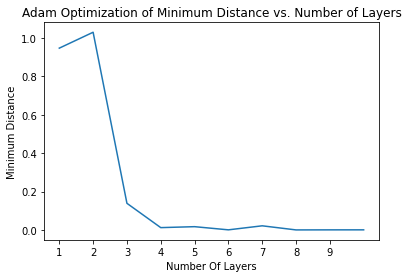

In [16]:
plt.title("Adam Optimization of Minimum Distance vs. Number of Layers")
plt.xlabel("Number Of Layers")
plt.ylabel("Minimum Distance")
plt.xticks(np.arange(10))
plt.plot([i for i in range(1,len(adam_results)+1)],adam_results)

## Conclusion
We can see that as the number of layers increases in the circuit, the minimum distance between these two vectors decreases quite substantially.
Cobyla seems to do a better job at getting the lowest values possible with a smaller number of layers, however Adam definitely performs better in the long run with more layers added.

## Room for Improvement
Definitely the most alarming part of this code is that I use the Random State as a global variable for use within the cost function. Ideally, this would be passed in as a parameter through the optimizer. I have been given some great resources by Michal, but I think I was running out of time before I would be able to be implementing anything like that. It definitely has peaked my interest though as I am keen to do more optimization work in future.

Also, I feel like I used COBYLA and Adam without really knowing exactly why. They both did similarly, but I'm not familiar with the mathematics behind what makes each optimizer perform differently.


# On to the Bonus Question
### "Try using other gates for the parametrized gates and see what happens"
My understanding of this is basically to transpile the circuit with a different combination of gates. Therefore, it makes sense that the only function that needs to change is how the circuit itself is constructed. I decided as a test to use CX and U3 gates. It at least seemed to work.

I also have changed the main() function too though - to have less layers and also just use the cobyla optimizer - in the interest of time as Adam took very long to run.

In [21]:
def main():
    """
    Changing this too to not worry about the ADAM Optimizer
    """
    #preparing optimizers
    cob,adam = optimizers()
    
    # where our results are stored
    returned_values_cobyla = []

    #new circuit for each number of layers
    for number_of_layers in range (1,6):

        # initialising between 0 and 2Pi
        params = [random.uniform(0,2*np.pi) for i in range(8 * number_of_layers)]
        
        bounds = []
        for param in params:
            bounds.append((0, 2*np.pi)) # bounds for optimiser

        ret1 = cob.optimize(num_vars=8 * number_of_layers,
                         objective_function=cost_function,
                         initial_point=params,
                         variable_bounds=bounds)
        returned_values_cobyla.append(ret1)
        print("---- Appended cobyla ----" + str(number_of_layers))
    
    #only returning the end Epsilon values (rather than also our thetas)
    cobyla_results = [i[1] for i in returned_values_cobyla]
        
    return cobyla_results

In [17]:
def construct_circuit(params):
    """Builds the circuit with the necessary number of layers"""
    circuit = QuantumCircuit(4)
    circuit = layer_calculation(circuit,params)
    transpiled_circuit = transpile(circuit, basis_gates = ['cx','u3'])
    return transpiled_circuit

This is what our new circuit will look like:

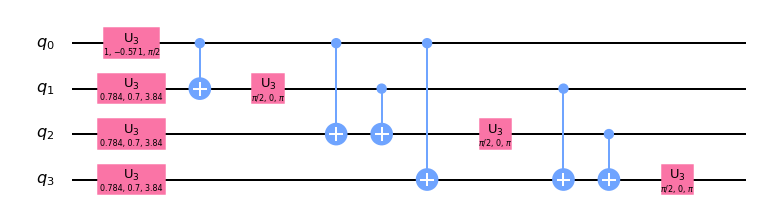

In [22]:
x = construct_circuit([1]*8)
x.draw()

In [23]:
cobyla_results = main()

---- Appended cobyla ----1
---- Appended cobyla ----2
---- Appended cobyla ----3
---- Appended cobyla ----4
---- Appended cobyla ----5


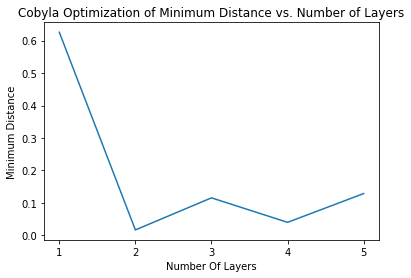

In [24]:
plt.title("Cobyla Optimization of Minimum Distance vs. Number of Layers")
plt.xlabel("Number Of Layers")
plt.ylabel("Minimum Distance")
plt.xticks(np.arange(6))
plt.plot([i for i in range(1,len(cobyla_results)+1)],cobyla_results)

## Thoughts
Similarly to before, COBYLA is struggling with more layers being added on. However, I can't see any huge difference between how this circuit performs differently to our original. Perhaps I misunderstood the bonus question!

